# 2020 Tokyo Olympic - Korea prediction

역대 올림픽 데이터를 이용

* 선수 개인의 성적이나 개최지 기온, 환경에 따른 영향 (feature)
* 한국의 역대 성적 (target)

=> 한국 메달 개수 / 순위 예측

# 라이브러리 및 데이터

In [1]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# 데이터 불러오기
athletes_2020 = pd.read_excel("Athletes.xlsx", sheet_name='Details')
coaches_2020 = pd.read_excel("Coaches.xlsx", sheet_name='Details')

noc_region_total = pd.read_csv("noc_regions.csv")
meta_host_total = pd.read_csv("olympic_metadata_host.csv")
host_total = pd.read_csv("olympic_hosts.csv")
medals_total = pd.read_csv("olympic_medals.csv")

gdp_total = pd.read_csv('total_gdp.CSV')
population = pd.read_csv('population.CSV')

# # 원본 데이터 불러올 시 parsererror 발생. column 9 delete 후 불러와야 함
# field_total = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Olympic/data/olympic_field_athletes.csv")
# event_total = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Olympic/data/olympic_athlete_events.csv")

In [3]:
noc_region_total.head()


,NOC,region,notes
0,AFG,Afghanistan,NaN
1,AHO,Curacao,Netherlands Antilles
2,ALB,Albania,NaN
3,ALG,Algeria,NaN
4,AND,Andorra,NaN


In [4]:
meta_host_total.head()

,game_slug,game_end_date,game_start_date,game_location,game_name,game_season,game_year
0,pyeongchang-2018,2018-02-25T08:00:00Z,2018-02-08T23:00:00Z,Republic of Korea,PyeongChang 2018,Winter,2018
1,rio-2016,2016-08-21T21:00:00Z,2016-08-05T12:00:00Z,Brazil,Rio 2016,Summer,2016
2,sochi-2014,2014-02-23T16:00:00Z,2014-02-07T04:00:00Z,Russian Federation,Sochi 2014,Winter,2014
3,london-2012,2012-08-12T19:00:00Z,2012-07-27T07:00:00Z,Great Britain,London 2012,Summer,2012
4,vancouver-2010,2010-02-28T04:00:00Z,2010-02-12T16:00:00Z,Canada,Vancouver 2010,Winter,2010


In [5]:
host_total.head()

,Type,GamesUrl,Disciplines,DisciplinesList,Country,Date,Athletes,Countries,Events,City,Year
0,summergames,https://www.olympic.org/athens-1896,10,"['Athletics', 'Cycling Road', 'Cycling Track',...",Greece,06 Apr - 15 Apr,241.0,14.0,43.0,Athens,1896
1,summergames,https://www.olympic.org/paris-1900,20,"['Archery', 'Athletics', 'Basque Pelota', 'Cri...",France,14 May - 28 Oct,997.0,24.0,95.0,Paris,1900
2,summergames,https://www.olympic.org/st-louis-1904,19,"['Archery', 'Athletics', 'Basketball', 'Boxing...",United States of America,01 Jul - 23 Nov,651.0,12.0,95.0,St Louis,1904
3,summergames,https://www.olympic.org/london-1908,25,"['Archery', 'Athletics', 'Boxing', 'Cycling Tr...",Great Britain,27 Apr - 31 Oct,2008.0,22.0,110.0,London,1908
4,summergames,https://www.olympic.org/stockholm-1912,18,"['Athletics', 'Cycling Road', 'Diving', 'Eques...",Sweden,05 May - 27 Jul,2407.0,28.0,102.0,Stockholm,1912


In [6]:
medals_total.head()

,Unnamed: 0,discipline_title,slug_game,event_title,event_gender,medal_type,participant_type,participant_title,athlete_name,athlete_surname,country_name,country_code,country_tri_letter_code
0,0,Skeleton,pyeongchang-2018,Women,Women,GOLD,Athlete,NaN,Lizzy,YARNOLD,Great Britain,GB,GBR
1,1,Skeleton,pyeongchang-2018,Women,Women,SILVER,Athlete,NaN,Jacqueline,LOELLING,Germany,DE,GER
2,2,Skeleton,pyeongchang-2018,Women,Women,BRONZE,Athlete,NaN,Laura,DEAS,Great Britain,GB,GBR
3,3,Skeleton,pyeongchang-2018,Men,Men,GOLD,Athlete,NaN,Sungbin,YUN,Republic of Korea,KR,KOR
4,4,Skeleton,pyeongchang-2018,Men,Men,SILVER,Athlete,NaN,Nikita,TREGUBOV,Olympic Athletes from Russia,NaN,OAR


In [7]:
# 𝑀𝑒𝑑𝑎𝑙𝑠𝑖𝑡 = 𝛽1 + 𝛽2𝐿𝑎𝑔 𝑀𝑒𝑑𝑎𝑙𝑠𝑖𝑡 + 𝛽3𝑌𝑒𝑎𝑟𝑡 + 𝜀𝑖𝑡,
# 𝑀𝑒𝑑𝑎𝑙𝑠𝑖𝑡 = 𝛾1 + 𝛾2𝐿𝑎𝑔 𝑀𝑒𝑑𝑎𝑙𝑠𝑖𝑡 + 𝛾3𝑙𝑛 𝐺𝐷𝑃𝑖𝑡 + 𝛾4 ln 𝑃𝑜𝑝𝑖𝑡 + 𝛾5𝐻𝑜𝑠𝑡𝑖𝑡 + 𝛾6𝑁𝑒𝑥𝑡 𝐻𝑜𝑠𝑡𝑖𝑡 +𝛾7𝑃𝑙𝑎𝑛𝑛𝑒𝑑𝑖𝑡 + 𝛾8𝑀𝑢𝑠𝑙𝑖𝑚𝑖𝑡 + 𝛾9𝑌𝑒𝑎𝑟𝑡 + 𝜁𝑖𝑡,

In [8]:
gdp_total.head()

,Unnamed: 0,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026
0,Afghanistan,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,18.91,18.401,18.876,19.132,19.938,21.201,22.01,22.754,23.896,24.553
1,Albania,1.946,2.229,2.296,2.319,2.29,2.339,2.587,2.566,2.53,...,13.053,15.147,15.276,15.147,17.138,18.32,19.662,21.009,22.422,23.903
2,Algeria,42.346,44.372,44.78,47.529,51.513,61.132,61.535,63.3,51.664,...,170.207,175.367,171.07,144.294,151.459,150.135,150.035,150.53,151.906,153.802
3,Angola,6.639,6.214,6.214,6.476,6.864,8.457,7.918,9.05,9.818,...,122.124,105.902,89.603,62.44,66.493,68.532,72.894,78.231,84.371,89.816
4,Antigua and Barbuda,0.131,0.148,0.164,0.182,0.208,0.241,0.29,0.337,0.399,...,1.468,1.605,1.662,1.39,1.376,1.57,1.702,1.838,1.947,2.046


In [9]:
population.head()

,Unnamed: 0,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026
0,Afghanistan,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,29.7,31.6,32.2,32.941,33.698,34.473,35.266,36.077,36.907,37.756
1,Albania,2.672,2.726,2.784,2.844,2.904,2.965,3.023,3.084,3.142,...,2.873,2.866,2.87,2.865,2.861,2.856,2.851,2.847,2.842,2.838
2,Algeria,18.666,19.246,19.864,20.516,21.175,22.2,22.8,23.4,24.1,...,41.721,42.578,43.424,44.227,45.024,45.799,46.553,47.286,47.998,48.723
3,Angola,8.91,9.151,9.393,9.639,9.894,11.149,11.467,11.76,12.079,...,28.377,29.25,30.128,31.031,31.962,32.921,33.909,34.926,35.974,37.053
4,Antigua and Barbuda,0.068,0.068,0.067,0.066,0.065,0.064,0.063,0.062,0.061,...,0.094,0.095,0.097,0.098,0.1,0.101,0.102,0.104,0.105,0.107


In [10]:
# for i in range(noc_region_total.shape[0]):
#     if noc_region_total['region'][i] in    

In [11]:
noc_region_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   NOC     230 non-null    object
 1   region  227 non-null    object
 2   notes   21 non-null     object
dtypes: object(3)
memory usage: 5.5+ KB


In [12]:
meta_host_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   game_slug        51 non-null     object
 1   game_end_date    51 non-null     object
 2   game_start_date  51 non-null     object
 3   game_location    51 non-null     object
 4   game_name        51 non-null     object
 5   game_season      51 non-null     object
 6   game_year        51 non-null     int64 
dtypes: int64(1), object(6)
memory usage: 2.9+ KB


In [13]:
host_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Type             63 non-null     object 
 1   GamesUrl         63 non-null     object 
 2   Disciplines      63 non-null     int64  
 3   DisciplinesList  63 non-null     object 
 4   Country          63 non-null     object 
 5   Date             61 non-null     object 
 6   Athletes         57 non-null     float64
 7   Countries        57 non-null     float64
 8   Events           57 non-null     float64
 9   City             63 non-null     object 
 10  Year             63 non-null     int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 5.5+ KB


In [14]:
medals_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20142 entries, 0 to 20141
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               20142 non-null  int64 
 1   discipline_title         20142 non-null  object
 2   slug_game                20142 non-null  object
 3   event_title              20142 non-null  object
 4   event_gender             20142 non-null  object
 5   medal_type               20142 non-null  object
 6   participant_type         20142 non-null  object
 7   participant_title        6060 non-null   object
 8   athlete_name             16762 non-null  object
 9   athlete_surname          16762 non-null  object
 10  country_name             20142 non-null  object
 11  country_code             18623 non-null  object
 12  country_tri_letter_code  20142 non-null  object
dtypes: int64(1), object(12)
memory usage: 2.0+ MB


In [15]:
gdp_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 48 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  227 non-null    object
 1   1980        227 non-null    object
 2   1981        227 non-null    object
 3   1982        227 non-null    object
 4   1983        227 non-null    object
 5   1984        227 non-null    object
 6   1985        227 non-null    object
 7   1986        227 non-null    object
 8   1987        227 non-null    object
 9   1988        227 non-null    object
 10  1989        227 non-null    object
 11  1990        227 non-null    object
 12  1991        227 non-null    object
 13  1992        227 non-null    object
 14  1993        227 non-null    object
 15  1994        227 non-null    object
 16  1995        227 non-null    object
 17  1996        227 non-null    object
 18  1997        227 non-null    object
 19  1998        227 non-null    object
 20  1999      

In [16]:
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 48 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  227 non-null    object
 1   1980        227 non-null    object
 2   1981        227 non-null    object
 3   1982        227 non-null    object
 4   1983        227 non-null    object
 5   1984        227 non-null    object
 6   1985        227 non-null    object
 7   1986        227 non-null    object
 8   1987        227 non-null    object
 9   1988        227 non-null    object
 10  1989        227 non-null    object
 11  1990        227 non-null    object
 12  1991        227 non-null    object
 13  1992        227 non-null    object
 14  1993        227 non-null    object
 15  1994        227 non-null    object
 16  1995        227 non-null    object
 17  1996        227 non-null    object
 18  1997        227 non-null    object
 19  1998        227 non-null    object
 20  1999      

# 전체 메달 수(회귀분석)

In [17]:
## 데이터 전처리

In [18]:
athletes_2020.head()

,Name,NOC,Discipline
0,AALERUD Katrine,Norway,Cycling Road
1,ABAD Nestor,Spain,Artistic Gymnastics
2,ABAGNALE Giovanni,Italy,Rowing
3,ABALDE Alberto,Spain,Basketball
4,ABALDE Tamara,Spain,Basketball


In [19]:
athletes_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11085 entries, 0 to 11084
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        11085 non-null  object
 1   NOC         11085 non-null  object
 2   Discipline  11085 non-null  object
dtypes: object(3)
memory usage: 259.9+ KB


In [20]:
total_country = athletes_2020.groupby('NOC').agg('count')['Name']
total_country_df = pd.DataFrame({'country_name':total_country.index, 'count':total_country}).reset_index(drop=True)
total_country_df

,country_name,count
0,Afghanistan,5
1,Albania,8
2,Algeria,41
3,American Samoa,5
4,Andorra,2
...,...,...
201,"Virgin Islands, British",3
202,"Virgin Islands, US",4
203,Yemen,3
204,Zambia,29


In [21]:
total_country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   country_name  206 non-null    object
 1   count         206 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.3+ KB


In [22]:
gdp = {}
total_country = total_country_df['country_name']

for i in range(gdp_total.shape[0]):
    for j in range(total_country_df.shape[0]):
        if gdp_total.iloc[i,0] in total_country[j]:
            gdp[f'{total_country[j]}']= gdp_total.iloc[i,1:]


In [23]:
gdp

{'Afghanistan': 1980    no data
 1981    no data
 1982    no data
 1983    no data
 1984    no data
 1985    no data
 1986    no data
 1987    no data
 1988    no data
 1989    no data
 1990    no data
 1991    no data
 1992    no data
 1993    no data
 1994    no data
 1995    no data
 1996    no data
 1997    no data
 1998    no data
 1999    no data
 2000    no data
 2001    no data
 2002      4.367
 2003      4.553
 2004      5.146
 2005      6.167
 2006      6.925
 2007      8.556
 2008     10.297
 2009     12.066
 2010     15.325
 2011      17.89
 2012     20.293
 2013      20.17
 2014     20.635
 2015      20.22
 2016     17.994
 2017      18.91
 2018     18.401
 2019     18.876
 2020     19.132
 2021     19.938
 2022     21.201
 2023      22.01
 2024     22.754
 2025     23.896
 2026     24.553
 Name: 0, dtype: object,
 'Albania': 1980     1.946
 1981     2.229
 1982     2.296
 1983     2.319
 1984      2.29
 1985     2.339
 1986     2.587
 1987     2.566
 1988      2.53
 1989 

In [24]:
gdp_df = pd.DataFrame(gdp)
gdp_df

,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,Australia,Austria,...,United Arab Emirates,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
1980,no data,1.946,42.346,6.639,0.131,233.696,no data,no data,162.628,80.923,...,40.415,2857.325,12.165,no data,0.121,69.841,35.357,no data,4.246,no data
1981,no data,2.229,44.372,6.214,0.148,189.802,no data,no data,188.067,70.121,...,45.002,3207.025,13.578,no data,0.114,78.367,17.617,no data,4.385,no data
1982,no data,2.296,44.78,6.214,0.164,94.25,no data,no data,186.709,70.111,...,41.848,3343.8,11.1,no data,0.114,79.998,23.369,no data,4.232,no data
1983,no data,2.319,47.529,6.476,0.182,116.267,no data,no data,179.151,71.032,...,38.345,3634.025,6.093,no data,0.117,79.672,35.204,no data,3.653,no data
1984,no data,2.29,51.513,6.864,0.208,130.544,no data,no data,196.777,67.007,...,38.012,4037.65,5.794,no data,0.144,57.826,61.171,no data,3.003,no data
1985,no data,2.339,61.132,8.457,0.241,98.599,no data,no data,174.067,68.624,...,37.31,4339,5.662,no data,0.132,59.865,19.045,no data,2.848,no data
1986,no data,2.587,61.535,7.918,0.29,118.565,no data,no data,181.147,97.375,...,29.568,4579.625,7.029,no data,0.128,60.877,43.009,no data,1.962,no data
1987,no data,2.566,63.3,9.05,0.337,121.561,no data,no data,212.712,121.771,...,32.466,4855.25,8.794,no data,0.139,46.854,53.385,no data,2.431,no data
1988,no data,2.53,51.664,9.818,0.399,142.386,no data,no data,270.594,133.591,...,32.999,5236.425,9.098,no data,0.158,60.378,29.501,no data,4.095,no data
1989,no data,2.779,52.558,11.421,0.439,91.352,no data,no data,307.72,133.263,...,38.09,5641.6,9.589,no data,0.154,44.672,7.991,no data,4.365,no data


In [25]:
gdp_df.columns

Index(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda',
       'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria',
       ...
       'United Arab Emirates', 'United States of America', 'Uruguay',
       'Uzbekistan', 'Vanuatu', 'Venezuela', 'Vietnam', 'Yemen', 'Zambia',
       'Zimbabwe'],
      dtype='object', length=175)

In [26]:
total_country

0                  Afghanistan
1                      Albania
2                      Algeria
3               American Samoa
4                      Andorra
                ...           
201    Virgin Islands, British
202         Virgin Islands, US
203                      Yemen
204                     Zambia
205                   Zimbabwe
Name: country_name, Length: 206, dtype: object

In [27]:
for i in range(total_country.shape[0]):
    if total_country[i] in gdp_df.columns:
        pass
    else: print(total_country[i])

Andorra
Bahamas
Bermuda
Cape Verde
Cayman Islands
Chinese Taipei
Congo
Cook Islands
Cuba
Côte d'Ivoire
Democratic Republic of the Congo
Federated States of Micronesia
Gambia
Great Britain
Guam
Hong Kong, China
Kyrgyzstan
Lao People's Democratic Republic
Liechtenstein
Monaco
North Macedonia
Palestine
People's Republic of China
ROC
Refugee Olympic Team
Republic of Korea
Sao Tome and Principe
Slovakia
St Vincent and the Grenadines
Virgin Islands, British
Virgin Islands, US


In [28]:
gdp['Bahamas'] = gdp_total.iloc[11,1:]
gdp['Chinese Taipei'] = gdp_total.iloc[176,1:]
gdp['Congo'] = gdp_total.iloc[39,1:]
gdp['Democratic Republic of the Congo'] = gdp_total.iloc[38,1:]
gdp["Côte d'Ivoire"] = gdp_total.iloc[44,1:]
gdp["Federated States of Micronesia"] = gdp_total.iloc[112,1:]
gdp["Gambia"] = gdp_total.iloc[61,1:]
gdp["Great Britain"] = gdp_total.iloc[184,1:]
gdp["Hong Kong, China"] = gdp_total.iloc[73,1:]
gdp["Kyrgyzstan"] = gdp_total.iloc[95,1:]
gdp["Lao People's Democratic Republic"] = gdp_total.iloc[93,1:]
gdp["People's Republic of China"] = gdp_total.iloc[36,1:]
gdp["Russia"] = gdp_total.iloc[143,1:]
gdp["Republic of Korea"] = gdp_total.iloc[89,1:]
gdp["Sao Tome and Principe"] = gdp_total.iloc[168,1:]
gdp["Slovakia"] = gdp_total.iloc[155,1:]
gdp["St Vincent and the Grenadines"] = gdp_total.iloc[146,1:]

In [29]:
gdp_df = pd.DataFrame(gdp).T
gdp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 192 entries, Afghanistan to St Vincent and the Grenadines
Data columns (total 47 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   1980    192 non-null    object
 1   1981    192 non-null    object
 2   1982    192 non-null    object
 3   1983    192 non-null    object
 4   1984    192 non-null    object
 5   1985    192 non-null    object
 6   1986    192 non-null    object
 7   1987    192 non-null    object
 8   1988    192 non-null    object
 9   1989    192 non-null    object
 10  1990    192 non-null    object
 11  1991    192 non-null    object
 12  1992    192 non-null    object
 13  1993    192 non-null    object
 14  1994    192 non-null    object
 15  1995    192 non-null    object
 16  1996    192 non-null    object
 17  1997    192 non-null    object
 18  1998    192 non-null    object
 19  1999    192 non-null    object
 20  2000    192 non-null    object
 21  2001    192 non-null    object


In [30]:
gdp_df.head()

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026
Afghanistan,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,18.91,18.401,18.876,19.132,19.938,21.201,22.01,22.754,23.896,24.553
Albania,1.946,2.229,2.296,2.319,2.29,2.339,2.587,2.566,2.53,2.779,...,13.053,15.147,15.276,15.147,17.138,18.32,19.662,21.009,22.422,23.903
Algeria,42.346,44.372,44.78,47.529,51.513,61.132,61.535,63.3,51.664,52.558,...,170.207,175.367,171.07,144.294,151.459,150.135,150.035,150.53,151.906,153.802
Angola,6.639,6.214,6.214,6.476,6.864,8.457,7.918,9.05,9.818,11.421,...,122.124,105.902,89.603,62.44,66.493,68.532,72.894,78.231,84.371,89.816
Antigua and Barbuda,0.131,0.148,0.164,0.182,0.208,0.241,0.29,0.337,0.399,0.439,...,1.468,1.605,1.662,1.39,1.376,1.57,1.702,1.838,1.947,2.046


In [31]:
gdp_df = gdp_df.iloc[:, 16:]

In [32]:
gdp_df.head()

,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026
Afghanistan,no data,no data,no data,no data,no data,no data,4.367,4.553,5.146,6.167,...,18.91,18.401,18.876,19.132,19.938,21.201,22.01,22.754,23.896,24.553
Albania,3.2,2.259,2.56,3.209,3.483,3.928,4.348,5.611,7.185,8.052,...,13.053,15.147,15.276,15.147,17.138,18.32,19.662,21.009,22.422,23.903
Algeria,46.941,48.178,48.188,48.845,54.749,54.745,56.761,67.864,85.327,103.198,...,170.207,175.367,171.07,144.294,151.459,150.135,150.035,150.53,151.906,153.802
Angola,7.994,9.388,7.958,7.526,11.166,10.93,15.286,17.813,23.552,36.971,...,122.124,105.902,89.603,62.44,66.493,68.532,72.894,78.231,84.371,89.816
Antigua and Barbuda,0.634,0.681,0.728,0.766,0.83,0.801,0.815,0.856,0.92,1.022,...,1.468,1.605,1.662,1.39,1.376,1.57,1.702,1.838,1.947,2.046


In [33]:
medals_total['year'] = pd.to_numeric(medals_total['slug_game'].str[-4:])
medals_total['city'] = medals_total['slug_game'].str[:-5]
medals_total = medals_total[medals_total['year']>=1992].drop(['slug_game', 'Unnamed: 0'],axis=1)
medals_total.head()

,discipline_title,event_title,event_gender,medal_type,participant_type,participant_title,athlete_name,athlete_surname,country_name,country_code,country_tri_letter_code,year,city
0,Skeleton,Women,Women,GOLD,Athlete,NaN,Lizzy,YARNOLD,Great Britain,GB,GBR,2018,pyeongchang
1,Skeleton,Women,Women,SILVER,Athlete,NaN,Jacqueline,LOELLING,Germany,DE,GER,2018,pyeongchang
2,Skeleton,Women,Women,BRONZE,Athlete,NaN,Laura,DEAS,Great Britain,GB,GBR,2018,pyeongchang
3,Skeleton,Men,Men,GOLD,Athlete,NaN,Sungbin,YUN,Republic of Korea,KR,KOR,2018,pyeongchang
4,Skeleton,Men,Men,SILVER,Athlete,NaN,Nikita,TREGUBOV,Olympic Athletes from Russia,NaN,OAR,2018,pyeongchang


In [34]:
medals = medals_total.groupby(['country_name', 'year']).agg('count')[['medal_type']]
medals.head()

medal_type
country_name year            
Afghanistan  2008           1
             2012           1
Algeria      1992           2
             1996           3
             2000           5

In [35]:
gdp_df.columns

Index(['1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022',
       '2023', '2024', '2025', '2026'],
      dtype='object')

In [36]:
year = [1996,  2000, 2004,2008, 2012, 2016,  2020] * len(gdp_df.index)
year.sort()
country = list(gdp_df.index) * 7
values = list(gdp_df.iloc[:, 0]) + list(gdp_df.iloc[:, 4])+list(gdp_df.iloc[:, 8])+list(gdp_df.iloc[:, 12])+list(gdp_df.iloc[:, 16])+list(gdp_df.iloc[:, 20])+list(gdp_df.iloc[:, 24])

In [37]:
len(values)

1344

In [38]:
len(country)

1344

In [39]:
total_dict = {'year':year, 'country': country, 'gdp': values}
total = pd.DataFrame(total_dict)
total.head()

,year,country,gdp
0,1996,Afghanistan,no data
1,1996,Albania,3.2
2,1996,Algeria,46.941
3,1996,Angola,7.994
4,1996,Antigua and Barbuda,0.634


In [40]:
medals.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 734 entries, ('Afghanistan', 2008) to ('Zimbabwe', 2008)
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   medal_type  734 non-null    int64
dtypes: int64(1)
memory usage: 9.1+ KB


In [41]:
medals.head()

medal_type
country_name year            
Afghanistan  2008           1
             2012           1
Algeria      1992           2
             1996           3
             2000           5

In [42]:
medals_ = medals.reset_index(drop = False)
medals_.columns = ['country', 'year', 'medals']

In [43]:
medals_.head()

,country,year,medals
0,Afghanistan,2008,1
1,Afghanistan,2012,1
2,Algeria,1992,2
3,Algeria,1996,3
4,Algeria,2000,5


In [44]:
population.head()

,Unnamed: 0,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026
0,Afghanistan,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,29.7,31.6,32.2,32.941,33.698,34.473,35.266,36.077,36.907,37.756
1,Albania,2.672,2.726,2.784,2.844,2.904,2.965,3.023,3.084,3.142,...,2.873,2.866,2.87,2.865,2.861,2.856,2.851,2.847,2.842,2.838
2,Algeria,18.666,19.246,19.864,20.516,21.175,22.2,22.8,23.4,24.1,...,41.721,42.578,43.424,44.227,45.024,45.799,46.553,47.286,47.998,48.723
3,Angola,8.91,9.151,9.393,9.639,9.894,11.149,11.467,11.76,12.079,...,28.377,29.25,30.128,31.031,31.962,32.921,33.909,34.926,35.974,37.053
4,Antigua and Barbuda,0.068,0.068,0.067,0.066,0.065,0.064,0.063,0.062,0.061,...,0.094,0.095,0.097,0.098,0.1,0.101,0.102,0.104,0.105,0.107


In [45]:
num = {}

for i in range(population.shape[0]):
    for j in range(total_country_df.shape[0]):
        if population.iloc[i,0] in total_country[j]:
            num[f'{total_country[j]}']= population.iloc[i,1:]


In [46]:
num_df = pd.DataFrame(num)
num_df

,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,Australia,Austria,...,United Arab Emirates,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
1980,no data,2.672,18.666,8.91,0.068,27.95,no data,no data,14.802,7.54,...,1.01,227.622,2.939,no data,0.115,14.952,54.18,no data,5.907,7.092
1981,no data,2.726,19.246,9.151,0.068,28.45,no data,no data,15.039,7.556,...,1.1,229.916,2.959,no data,0.119,15.41,55.31,no data,6.101,7.3
1982,no data,2.784,19.864,9.393,0.067,28.93,no data,no data,15.289,7.565,...,1.17,232.128,2.978,no data,0.123,15.868,56.4,no data,6.297,7.606
1983,no data,2.844,20.516,9.639,0.066,29.34,no data,no data,15.483,7.543,...,1.21,234.247,2.997,no data,0.126,16.316,57.47,no data,6.495,7.849
1984,no data,2.904,21.175,9.894,0.065,29.84,no data,no data,15.677,7.544,...,1.31,236.307,3.016,no data,0.13,16.773,58.57,no data,6.695,8.099
1985,no data,2.965,22.2,11.149,0.064,30.35,no data,no data,15.901,7.549,...,1.38,238.416,3.035,no data,0.135,17.241,59.71,no data,6.897,8.385
1986,no data,3.023,22.8,11.467,0.063,30.74,no data,0.061,16.139,7.557,...,1.44,240.593,3.053,no data,0.139,17.45,60.92,no data,7.104,8.648
1987,no data,3.084,23.4,11.76,0.062,31.09,no data,0.06,16.395,7.567,...,1.5,242.751,3.07,no data,0.141,17.888,62.3,no data,7.317,8.919
1988,no data,3.142,24.1,12.079,0.061,31.47,no data,0.061,16.687,7.576,...,1.79,244.968,3.088,no data,0.145,18.336,63.5,no data,7.538,9.199
1989,no data,3.228,24.7,12.41,0.06,31.86,no data,0.062,16.937,7.594,...,1.86,247.286,3.105,no data,0.146,18.784,64.774,no data,7.769,9.488


In [47]:
for i in range(total_country.shape[0]):
    if total_country[i] in num_df.columns:
        pass
    else: print(total_country[i])

Andorra
Bahamas
Bermuda
Cape Verde
Cayman Islands
Chinese Taipei
Congo
Cook Islands
Cuba
Côte d'Ivoire
Democratic Republic of the Congo
Federated States of Micronesia
Gambia
Great Britain
Guam
Hong Kong, China
Kyrgyzstan
Lao People's Democratic Republic
Liechtenstein
Monaco
North Macedonia
Palestine
People's Republic of China
ROC
Refugee Olympic Team
Republic of Korea
Sao Tome and Principe
Slovakia
St Vincent and the Grenadines
Virgin Islands, British
Virgin Islands, US


In [48]:
num['Bahamas'] = population.iloc[11,1:]
num['Chinese Taipei'] = population.iloc[176,1:]
num['Congo'] = population.iloc[39,1:]
num['Democratic Republic of the Congo'] = population.iloc[38,1:]
num["Côte d'Ivoire"] = population.iloc[44,1:]
num["Federated States of Micronesia"] = population.iloc[112,1:]
num["Gambia"] = population.iloc[61,1:]
num["Great Britain"] = population.iloc[184,1:]
num["Hong Kong, China"] = population.iloc[73,1:]
num["Kyrgyzstan"] = population.iloc[95,1:]
num["Lao People's Democratic Republic"] = population.iloc[93,1:]
num["People's Republic of China"] = population.iloc[36,1:]
num["Russia"] = population.iloc[143,1:]
num["Republic of Korea"] = population.iloc[89,1:]
num["Sao Tome and Principe"] = population.iloc[168,1:]
num["Slovakia"] = population.iloc[155,1:]
num["St Vincent and the Grenadines"] = population.iloc[146,1:]

In [49]:
num_df = pd.DataFrame(num).T
num_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 192 entries, Afghanistan to St Vincent and the Grenadines
Data columns (total 47 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   1980    192 non-null    object
 1   1981    192 non-null    object
 2   1982    192 non-null    object
 3   1983    192 non-null    object
 4   1984    192 non-null    object
 5   1985    192 non-null    object
 6   1986    192 non-null    object
 7   1987    192 non-null    object
 8   1988    192 non-null    object
 9   1989    192 non-null    object
 10  1990    192 non-null    object
 11  1991    192 non-null    object
 12  1992    192 non-null    object
 13  1993    192 non-null    object
 14  1994    192 non-null    object
 15  1995    192 non-null    object
 16  1996    192 non-null    object
 17  1997    192 non-null    object
 18  1998    192 non-null    object
 19  1999    192 non-null    object
 20  2000    192 non-null    object
 21  2001    192 non-null    object


In [50]:
num_df = num_df.iloc[:, 16:]

In [51]:
num_values = list(num_df.iloc[:, 0]) + list(num_df.iloc[:, 4])+list(num_df.iloc[:, 8])+list(num_df.iloc[:, 12])+list(num_df.iloc[:, 16])+list(num_df.iloc[:, 20])+list(num_df.iloc[:, 24])
total['population'] = num_values
total.head()

,year,country,gdp,population
0,1996,Afghanistan,no data,no data
1,1996,Albania,3.2,3.168
2,1996,Algeria,46.941,28.566
3,1996,Angola,7.994,15.214
4,1996,Antigua and Barbuda,0.634,0.068


In [52]:
medals_.head()

,country,year,medals
0,Afghanistan,2008,1
1,Afghanistan,2012,1
2,Algeria,1992,2
3,Algeria,1996,3
4,Algeria,2000,5


In [53]:
medals_before = medals_.copy()
medals_before['year'] = medals_before['year']+4
medals_before.head()

,country,year,medals
0,Afghanistan,2012,1
1,Afghanistan,2016,1
2,Algeria,1996,2
3,Algeria,2000,3
4,Algeria,2004,5


In [54]:
medals_.columns = ['country','year','current_medals']
medals_before.columns = ['country','year','before_medals']

In [55]:
medal_num = pd.merge(medals_, medals_before, on=['country', 'year'], how = 'outer').fillna(0)
medal_num.head()

,country,year,current_medals,before_medals
0,Afghanistan,2008,1.0,0.0
1,Afghanistan,2012,1.0,1.0
2,Algeria,1992,2.0,0.0
3,Algeria,1996,3.0,2.0
4,Algeria,2000,5.0,3.0


In [56]:
total.head()

,year,country,gdp,population
0,1996,Afghanistan,no data,no data
1,1996,Albania,3.2,3.168
2,1996,Algeria,46.941,28.566
3,1996,Angola,7.994,15.214
4,1996,Antigua and Barbuda,0.634,0.068


In [57]:
total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1344 entries, 0 to 1343
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   year        1344 non-null   int64 
 1   country     1344 non-null   object
 2   gdp         1344 non-null   object
 3   population  1344 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.1+ KB


In [58]:
medal_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 935 entries, 0 to 934
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         935 non-null    object 
 1   year            935 non-null    int64  
 2   current_medals  935 non-null    float64
 3   before_medals   935 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 36.5+ KB


In [59]:
total1 = pd.merge(total, medal_num, on=['country', 'year'], how = 'outer').fillna(0)
total1.head(10)

,year,country,gdp,population,current_medals,before_medals
0,1996,Afghanistan,no data,no data,0.0,0.0
1,1996,Albania,3.2,3.168,0.0,0.0
2,1996,Algeria,46.941,28.566,3.0,2.0
3,1996,Angola,7.994,15.214,0.0,0.0
4,1996,Antigua and Barbuda,0.634,0.068,0.0,0.0
5,1996,Argentina,304.282,35.196,3.0,2.0
6,1996,Armenia,1.597,3.17,2.0,0.0
7,1996,Aruba,1.38,0.083,0.0,0.0
8,1996,Australia,423.544,18.33,51.0,30.0
9,1996,Austria,237.343,7.959,3.0,24.0


In [60]:
total1['gdp'] = total1['gdp'].replace('no data', float('nan'))
total1['population'] = total1['population'].replace('no data', float('nan'))
total1.head(10)

,year,country,gdp,population,current_medals,before_medals
0,1996,Afghanistan,NaN,NaN,0.0,0.0
1,1996,Albania,3.2,3.168,0.0,0.0
2,1996,Algeria,46.941,28.566,3.0,2.0
3,1996,Angola,7.994,15.214,0.0,0.0
4,1996,Antigua and Barbuda,0.634,0.068,0.0,0.0
5,1996,Argentina,304.282,35.196,3.0,2.0
6,1996,Armenia,1.597,3.17,2.0,0.0
7,1996,Aruba,1.38,0.083,0.0,0.0
8,1996,Australia,423.544,18.33,51.0,30.0
9,1996,Austria,237.343,7.959,3.0,24.0


## 개최국 및 이후 개최국 변수

In [61]:
host_total.head()

,Type,GamesUrl,Disciplines,DisciplinesList,Country,Date,Athletes,Countries,Events,City,Year
0,summergames,https://www.olympic.org/athens-1896,10,"['Athletics', 'Cycling Road', 'Cycling Track',...",Greece,06 Apr - 15 Apr,241.0,14.0,43.0,Athens,1896
1,summergames,https://www.olympic.org/paris-1900,20,"['Archery', 'Athletics', 'Basque Pelota', 'Cri...",France,14 May - 28 Oct,997.0,24.0,95.0,Paris,1900
2,summergames,https://www.olympic.org/st-louis-1904,19,"['Archery', 'Athletics', 'Basketball', 'Boxing...",United States of America,01 Jul - 23 Nov,651.0,12.0,95.0,St Louis,1904
3,summergames,https://www.olympic.org/london-1908,25,"['Archery', 'Athletics', 'Boxing', 'Cycling Tr...",Great Britain,27 Apr - 31 Oct,2008.0,22.0,110.0,London,1908
4,summergames,https://www.olympic.org/stockholm-1912,18,"['Athletics', 'Cycling Road', 'Diving', 'Eques...",Sweden,05 May - 27 Jul,2407.0,28.0,102.0,Stockholm,1912


In [62]:
host = host_total[host_total['Type']=='summergames'][['Country', 'Year']]
host.columns = ['country', 'year']
host.head()

,country,year
0,Greece,1896
1,France,1900
2,United States of America,1904
3,Great Britain,1908
4,Sweden,1912


In [63]:
host.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31 entries, 0 to 62
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   country  31 non-null     object
 1   year     31 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 744.0+ bytes


In [64]:
host = host[(host['year']>=1996) & (host['year']<=2024)]
host.tail()

,country,year
45,People's Republic of China,2008
49,Great Britain,2012
53,Brazil,2016
56,Japan,2020
60,France,2024


In [65]:
host1 = host.copy()
host1['year'] = host1['year']-4

In [66]:
host['host']=1
host.head()

,country,year,host
39,United States of America,1996,1
41,Australia,2000,1
43,Greece,2004,1
45,People's Republic of China,2008,1
49,Great Britain,2012,1


In [67]:
host.tail()

,country,year,host
45,People's Republic of China,2008,1
49,Great Britain,2012,1
53,Brazil,2016,1
56,Japan,2020,1
60,France,2024,1


In [68]:
host = host.iloc[:-1, :]
host.tail()

,country,year,host
43,Greece,2004,1
45,People's Republic of China,2008,1
49,Great Britain,2012,1
53,Brazil,2016,1
56,Japan,2020,1


In [69]:

host1.head()

,country,year
39,United States of America,1992
41,Australia,1996
43,Greece,2000
45,People's Republic of China,2004
49,Great Britain,2008


In [70]:
host1['next_host'] = 1
host1 = host1.iloc[1:,:]
host1.head()

,country,year,next_host
41,Australia,1996,1
43,Greece,2000,1
45,People's Republic of China,2004,1
49,Great Britain,2008,1
53,Brazil,2012,1


In [71]:
total2 = total1.dropna(axis=0)
tt_ = pd.merge(total2, host, on=['year', 'country'], how = 'outer')
total_ = pd.merge(host1, tt_, on=['year', 'country'], how = 'outer')
total_.head(10)

,country,year,next_host,gdp,population,current_medals,before_medals,host
0,Australia,1996,1.0,423.544,18.33,51.0,30.0,NaN
1,Greece,2000,1.0,131.082,10.776,13.0,8.0,NaN
2,People's Republic of China,2004,1.0,116.335,42.368,74.0,70.0,NaN
3,Great Britain,2008,1.0,2952.326,61.824,56.0,37.0,NaN
4,Brazil,2012,1.0,2464.054,198.315,20.0,21.0,NaN
5,Japan,2016,1.0,5003.678,126.96,43.0,39.0,NaN
6,France,2020,1.0,2598.907,65.124,0.0,45.0,NaN
7,Albania,1996,NaN,3.2,3.168,0.0,0.0,NaN
8,Algeria,1996,NaN,46.941,28.566,3.0,2.0,NaN
9,Angola,1996,NaN,7.994,15.214,0.0,0.0,NaN


In [72]:
total3 = total_.fillna(0)
total3

,country,year,next_host,gdp,population,current_medals,before_medals,host
0,Australia,1996,1.0,423.544,18.33,51.0,30.0,0.0
1,Greece,2000,1.0,131.082,10.776,13.0,8.0,0.0
2,People's Republic of China,2004,1.0,116.335,42.368,74.0,70.0,0.0
3,Great Britain,2008,1.0,2952.326,61.824,56.0,37.0,0.0
4,Brazil,2012,1.0,2464.054,198.315,20.0,21.0,0.0
...,...,...,...,...,...,...,...,...
1631,Ukraine,2010,0.0,0,0,0.0,3.0,0.0
1632,Ukraine,2022,0.0,0,0,0.0,1.0,0.0
1633,Unified Team,1996,0.0,0,0,0.0,141.0,0.0
1634,United States of America,2022,0.0,0,0,0.0,26.0,0.0


In [73]:
total3['gdp'] = [float (i) for i in total3['gdp']]
total3['population'] = [float (i) for i in total3['population']]

In [74]:
total5 = total3[(total3['year']!=2020) & (total3['gdp']!=0) & (total3['population']!=0)]

In [ ]:
total6 = total3[(total3['gdp']!=0) & (total3['population']!=0)]

In [75]:
total4 = total6.drop('country', axis=1)

<AxesSubplot:xlabel='gdp', ylabel='current_medals'>

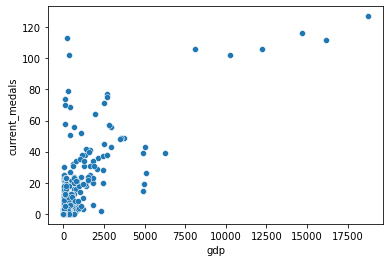

In [76]:
sns.scatterplot(x='gdp', y='current_medals', data=total5)

<AxesSubplot:xlabel='population', ylabel='current_medals'>

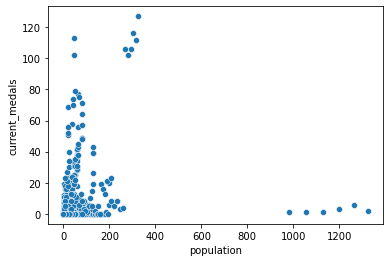

In [77]:
sns.scatterplot(x='population', y='current_medals', data=total5)

<AxesSubplot:xlabel='gdp', ylabel='current_medals'>

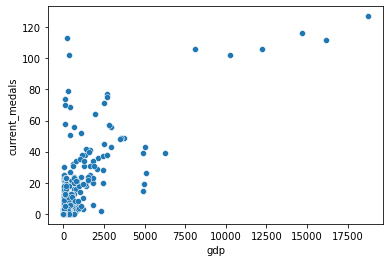

In [78]:
sns.scatterplot(x='gdp', y='current_medals', data=total5)

Text(0.5, 1.0, 'Brazil-2016')

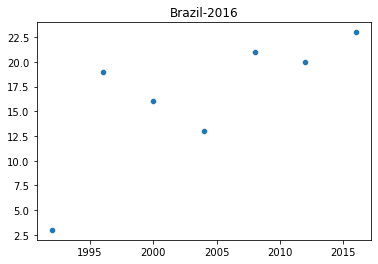

In [79]:
y = [23,20,21,13,16,19,3]
x = [2016,2012,2008,2004,2000,1996,1992]
sns.scatterplot(x=x, y=y)
plt.title('Brazil-2016')

Text(0.5, 1.0, 'Great Britain-2012')

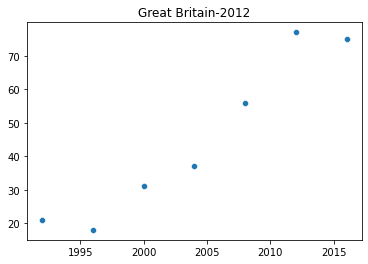

In [80]:
x= [2016,2012,2008,2004,2000,1996,1992]
y= [75,77,56,37,31,18,21]
sns.scatterplot(x=x, y=y)
plt.title('Great Britain-2012')

Text(0.5, 1.0, 'China-2008')

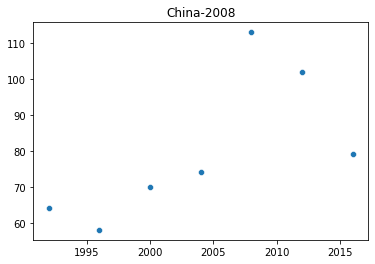

In [81]:
x= [2016,2012,2008,2004,2000,1996,1992]
y= [79,102,113,74,70,58,64]
sns.scatterplot(x=x, y=y)
plt.title('China-2008')

Text(0.5, 1.0, 'Greece-2004')

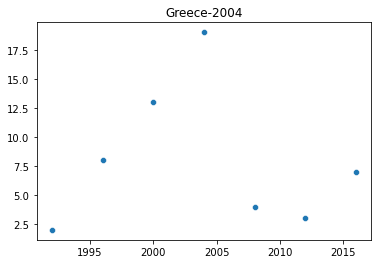

In [82]:
x= [2012,2008,2004,2016,2000,1996,1992]
y= [3,4,19,7,13,8,2]
sns.scatterplot(x=x, y=y)
plt.title('Greece-2004')

<AxesSubplot:xlabel='host', ylabel='current_medals'>

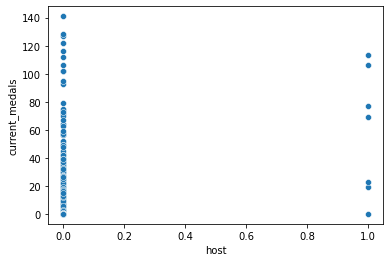

In [83]:
sns.scatterplot(x='host', y='current_medals', data=total3)

In [84]:
total4['gdp'] = [float (i) for i in total4['gdp']]
total4['population'] = [float (i) for i in total4['population']]

## 데이터 확인

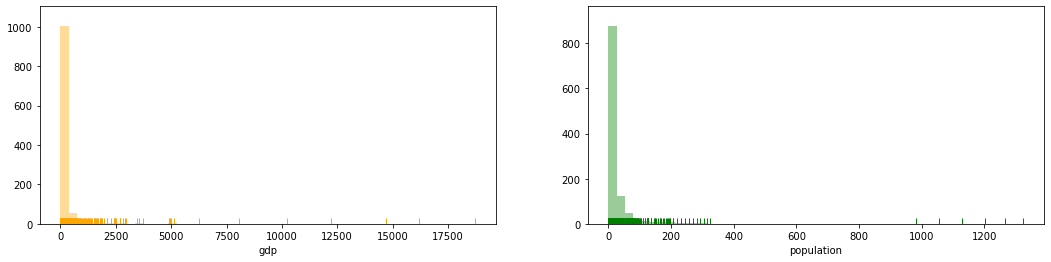

In [85]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 4))
sns.distplot(total4['gdp'], ax = ax[0], color = 'orange', kde = False, rug = True)
sns.distplot(total4['population'], ax = ax[1], color = 'green', kde = False, rug = True)
plt.show()

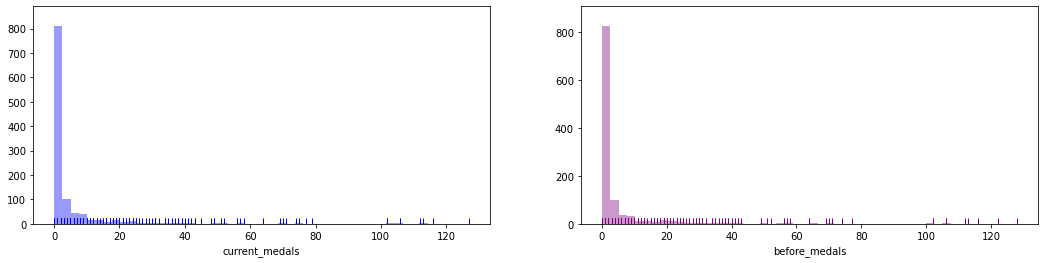

In [86]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 4))
sns.distplot(total4['current_medals'], ax = ax[0], color = 'blue', kde = False, rug = True)
sns.distplot(total4['before_medals'], ax = ax[1], color = 'purple', kde = False, rug = True)
plt.show()

In [87]:
total4.head()

,year,next_host,gdp,population,current_medals,before_medals,host
0,1996,1.0,423.544,18.330,51.0,30.0,0.0
1,2000,1.0,131.082,10.776,13.0,8.0,0.0
2,2004,1.0,116.335,42.368,74.0,70.0,0.0
3,2008,1.0,2952.326,61.824,56.0,37.0,0.0
4,2012,1.0,2464.054,198.315,20.0,21.0,0.0


In [88]:
total4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1126 entries, 0 to 1126
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            1126 non-null   int64  
 1   next_host       1126 non-null   float64
 2   gdp             1126 non-null   float64
 3   population      1126 non-null   float64
 4   current_medals  1126 non-null   float64
 5   before_medals   1126 non-null   float64
 6   host            1126 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 70.4 KB


로그를 이용하여 교정 -> 0이 있을 수도 있으므로 log(x+10)
current_medals에도 로그를 취해야 하는지? 우선 x

In [135]:
import math
gdp = []
population = []
current = []
before = []


for i in total4['gdp']:
    gdp.append(math.log(i+10))
for i in total4['population']:
    population.append(math.log(i+10))
# for i in total4['current_medals']:
#     current.append(math.log(i+10))
# for i in total4['before_medals']:
#     before.append(math.log(i+10))

In [136]:
total4['gdp'] = gdp
total4['population'] = population


<AxesSubplot:xlabel='population'>

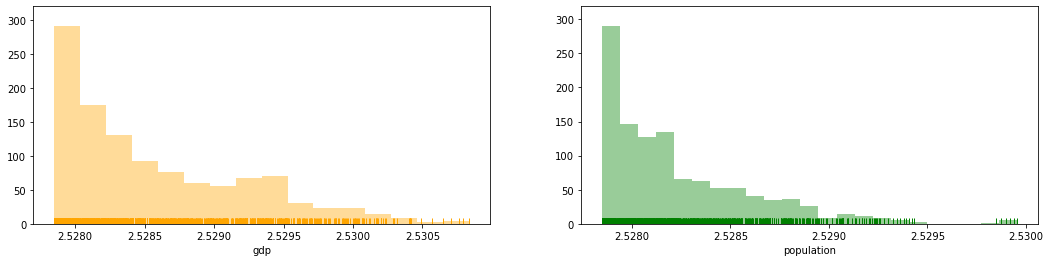

In [137]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 4))
sns.distplot(total4['gdp'], ax = ax[0], color = 'orange', kde = False, rug = True)
sns.distplot(total4['population'], ax = ax[1], color = 'green', kde = False, rug = True)

In [92]:
total_2021 = total4[total4['year']==2020]
total_train = total4[total4['year']!=2020]

In [93]:
corr = total_train.corr()
corr.style.background_gradient(cmap='YlGnBu')

,year,next_host,gdp,population,current_medals,before_medals,host
year,1.000000,-0.001726,0.161045,0.043083,0.011450,0.005908,-0.001726
next_host,-0.001726,1.000000,0.136409,0.096509,0.206104,0.157024,-0.005357
gdp,0.161045,0.136409,1.000000,0.697142,0.608197,0.602623,0.146660
population,0.043083,0.096509,0.697142,1.000000,0.422503,0.410589,0.109360
current_medals,0.011450,0.206104,0.608197,0.422503,1.000000,0.961741,0.341803
before_medals,0.005908,0.157024,0.602623,0.410589,0.961741,1.000000,0.278970
host,-0.001726,-0.005357,0.146660,0.109360,0.341803,0.278970,1.000000


In [94]:
corr1 = total3.corr()
corr.style.background_gradient(cmap='viridis')

,year,next_host,gdp,population,current_medals,before_medals,host
year,1.000000,-0.001726,0.161045,0.043083,0.011450,0.005908,-0.001726
next_host,-0.001726,1.000000,0.136409,0.096509,0.206104,0.157024,-0.005357
gdp,0.161045,0.136409,1.000000,0.697142,0.608197,0.602623,0.146660
population,0.043083,0.096509,0.697142,1.000000,0.422503,0.410589,0.109360
current_medals,0.011450,0.206104,0.608197,0.422503,1.000000,0.961741,0.341803
before_medals,0.005908,0.157024,0.602623,0.410589,0.961741,1.000000,0.278970
host,-0.001726,-0.005357,0.146660,0.109360,0.341803,0.278970,1.000000


## 2020 data를 2021로 변경(before medals 제외) -> 주석처리

In [95]:
gdp_df['2021']

Afghanistan                        19.938
Albania                            17.138
Algeria                           151.459
Angola                             66.493
Antigua and Barbuda                 1.376
                                   ...   
Russia                             10.633
Republic of Korea                1806.707
Sao Tome and Principe               0.485
Slovakia                          117.664
St Vincent and the Grenadines       0.798
Name: 2021, Length: 192, dtype: object

In [96]:
#total_2021['gdp'] = gdp_df['2021']
#total_2021['population'] = num_df['2021']
#total_2021['year'] = 2021
total_2021_train = total_2021.drop('current_medals', axis=1)

In [97]:
#total_2021_train.head()

## 회귀분석

In [98]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression


In [99]:
rf = RandomForestRegressor()
svr = SVR()
lr = LinearRegression()
xgb = XGBRegressor()
lgbm = LGBMRegressor()

In [101]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(random_state=0).fit(feature)
y_pred_outliers = clf.predict(feature)


In [102]:
y_pred_outliers.shape

(1126,)

In [103]:
feature.shape

(1126, 6)

In [104]:
outlier = pd.DataFrame(y_pred_outliers)
outlier.shape

(1126, 1)

In [105]:
feature1 = pd.concat([total_train,outlier], axis=1)
feature1.head()

,year,next_host,gdp,population,current_medals,before_medals,host,0
0,1996.0,1.0,6.071993,3.343921,51.0,30.0,0.0,-1.0
1,2000.0,1.0,4.949341,3.033798,13.0,8.0,0.0,-1.0
2,2004.0,1.0,4.838937,3.958296,74.0,70.0,0.0,-1.0
3,2008.0,1.0,7.993730,4.274219,56.0,37.0,0.0,-1.0
4,2012.0,1.0,7.813613,5.339051,20.0,21.0,0.0,-1.0


In [100]:
target = total_train['current_medals']
feature = total_train.drop('current_medals', axis=1)

In [106]:
feature1.shape

(1127, 8)

In [107]:
feature1.tail()

,year,next_host,gdp,population,current_medals,before_medals,host,0
1122,2016.0,0.0,2.930340,3.068053,0.0,0.0,0.0,-1.0
1123,2016.0,0.0,7.319442,4.114441,22.0,31.0,0.0,1.0
1124,2016.0,0.0,2.336793,2.322388,0.0,0.0,0.0,1.0
1125,2016.0,0.0,4.602075,2.736054,5.0,5.0,0.0,1.0
1126,2016.0,0.0,2.377136,2.313525,0.0,0.0,0.0,NaN


In [108]:
# feature1.to_csv('feature34.csv')

In [109]:
target.shape

(1126,)

In [118]:
# total_train2 = pd.read_csv('feature34.csv')

In [119]:
total_train3 = total_train2.iloc[:,1:]
total_train3.columns = ['year','next_host','gdp','population','current_medals','before_medals','host','outlier']
total_train3.head()

,year,next_host,gdp,population,current_medals,before_medals,host,outlier
0,1996.0,1.0,6.071993,3.343921,51.0,30.0,0.0,-1.0
1,2000.0,1.0,4.949341,3.033798,13.0,8.0,0.0,-1.0
2,2004.0,1.0,4.838937,3.958296,74.0,70.0,0.0,-1.0
3,2008.0,1.0,7.993730,4.274219,56.0,37.0,0.0,-1.0
4,2012.0,1.0,7.813613,5.339051,20.0,21.0,0.0,-1.0


In [120]:
total_train4 = total_train3[total_train3['outlier']!=-1]
total_train4.head()

,year,next_host,gdp,population,current_medals,before_medals,host,outlier
6,1996.0,0.0,2.580217,2.577790,0.0,0.0,0.0,1.0
7,1996.0,0.0,4.042016,3.652371,3.0,2.0,0.0,1.0
8,1996.0,0.0,2.890038,3.227399,0.0,0.0,0.0,1.0
9,1996.0,0.0,2.364056,2.309362,0.0,0.0,0.0,1.0
11,1996.0,0.0,2.450746,2.577942,2.0,0.0,0.0,1.0


In [121]:
target = total_train4['current_medals']
feature = total_train4.drop(['current_medals','outlier'], axis=1)

In [122]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2)

In [126]:
feature1.head()

,year,next_host,gdp,population,before_medals,host
6,1996.0,0.0,2.580217,2.577790,0.0,0.0
7,1996.0,0.0,4.042016,3.652371,2.0,0.0
8,1996.0,0.0,2.890038,3.227399,0.0,0.0
9,1996.0,0.0,2.364056,2.309362,0.0,0.0
11,1996.0,0.0,2.450746,2.577942,0.0,0.0


In [123]:
feature1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 960 entries, 6 to 1126
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           959 non-null    float64
 1   next_host      959 non-null    float64
 2   gdp            959 non-null    float64
 3   population     959 non-null    float64
 4   before_medals  959 non-null    float64
 5   host           959 non-null    float64
dtypes: float64(6)
memory usage: 52.5 KB


In [128]:
# feature1.to_csv('feature00.csv')
target.head()

6     0.0
7     3.0
8     0.0
9     0.0
11    2.0
Name: current_medals, dtype: float64

In [124]:
from sklearn.metrics import mean_absolute_error as MAE
def model_fit(model_list, train_X, train_y, test_X, test_y):
  for model in model_list:
    model.fit(train_X, train_y)
    mae = MAE(test_y, model.predict(test_X))
    print(model.__class__.__name__, "\nmae: ", mae)

In [125]:
model_list = [rf, svr, lr, xgb, lgbm]
model_fit(model_list, X_train, y_train, X_test, y_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

# 하이퍼 파라미터 튜닝
# 메달 개수 -> 0이상의 정수


In [ ]:
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [ ]:
def rf_(trial: Trial) -> float:
    params_rf = {
        "n_estimators": trial.suggest_int("n_estimators", 1, 100),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 10),
        "max_features": "auto",
        "max_depth": trial.suggest_int("max_depth", 10, 100),
        "max_leaf_nodes": None
    }
    

    model = RandomForestRegressor(**params_rf)
    model.fit(
        X_train, y_train
    )

    predicts = model.predict(X_test)
    trans = []
    for i in predicts:
        trans.append(i)
    mae = MAE(y_test, trans)
    
    return mae

In [ ]:
def xgb_(trial: Trial) -> float:
    params_xgb = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": 10000,
        "objective": "reg:linear",
        "metric": "mae",
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 3e-5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-1),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "num_leaves": trial.suggest_int("num_leaves", 100, 200),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "subsample": trial.suggest_float("subsample", 0.1, 0.5),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 20),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }

    model = XGBRegressor(**params_xgb)
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=100,
        verbose=False,
    )

    predicts = model.predict(X_test)
    trans = []
    for i in predicts:
        trans.append(i)
    mae = MAE(y_test, trans)
    
    return mae

In [ ]:
def lgbm_(trial: Trial) -> float:
    params_lgb = {
        "verbosity": -1,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "n_estimators": 10000,
        "objective": "regression",
        "metric": "mae",
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-6, 9e-5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 9e-2),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "num_leaves": trial.suggest_int("num_leaves", 50, 100),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.8, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 20),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    

    model = LGBMRegressor(**params_lgb)
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=100,
        verbose=False,
    )

    predicts = model.predict(X_test)
    trans = []
    for i in predicts:
        trans.append(i)
    mae = MAE(y_test, trans)
    
    return mae

In [ ]:
def svr_(trial: Trial) -> float:
    params_svr = {"kernel": trial.suggest_categorical("kernel", ['poly', 'sigmoid', 'rbf']),
                  "C": trial.suggest_int('C', 1,10),
                  'epsilon': trial.suggest_float('epsilon', 0.1, 0.5)
    }
    
    model = SVR(**params_svr)
    model.fit(
        X_train, y_train
    )

    predicts = model.predict(X_test)
    trans = []
    for i in predicts:
        trans.append(i)
    mae = MAE(y_test, trans)
    
    return mae

In [ ]:
sampler = TPESampler()
study_lgbm = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study_lgbm.optimize(lgbm_, n_trials=150)
print("Best Score:", study_lgbm.best_value)
print("Best trial:", study_lgbm.best_trial.params)

In [ ]:
sampler = TPESampler()
study_xgb = optuna.create_study(
    study_name="xgb_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study_xgb.optimize(xgb_, n_trials=150)
print("Best Score:", study_xgb.best_value)
print("Best trial:", study_xgb.best_trial.params)

In [ ]:
# sampler = TPESampler()
# study_lr = optuna.create_study(
#     study_name="lr_parameter_opt",
#     direction="minimize",
#     sampler=sampler,
# )
# study_lr.optimize(lr_, n_trials=150)
# print("Best Score:", study_lr.best_value)
# print("Best trial:", study_lr.best_trial.params)

In [ ]:
sampler = TPESampler()
study_svr = optuna.create_study(
    study_name="svr_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study_svr.optimize(svr_, n_trials=150)
print("Best Score:", study_svr.best_value)
print("Best trial:", study_svr.best_trial.params)

In [ ]:
sampler = TPESampler()
study_rf = optuna.create_study(
    study_name="rf_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study_rf.optimize(rf_, n_trials=150)
print("Best Score:", study_rf.best_value)
print("Best trial:", study_rf.best_trial.params)

In [ ]:
best_lgbm = LGBMRegressor(**study_lgbm.best_trial.params)
best_xgb = XGBRegressor(**study_xgb.best_trial.params)
best_rf = RandomForestRegressor(**study_rf.best_trial.params)
best_svr = SVR(**study_svr.best_trial.params)

In [ ]:
best_rf.fit(X_train, y_train)
best_lgbm.fit(X_train, y_train)
best_xgb.fit(X_train, y_train)
best_svr.fit(X_train, y_train)

In [ ]:
best_xgbs = []
best_lgbms = []
best_rfs = []
best_svrs = []

best1 = best_xgb.predict(X_test)
best2 = best_lgbm.predict(X_test)
best3 = best_rf.predict(X_test)
best4 =  best_svr.predict(X_test)
for i in best1:
    best_xgbs.append((np.exp(i))-10)

for i in best2:
    best_lgbms.append((np.exp(i))-10)

for i in best3:
    best_rfs.append((np.exp(i))-10)

for i in best4:
    best_svrs.append((np.exp(i))-10)

# print('rf', MAE(y_test, best_rfs))
# print('svr', MAE(y_test, best_svrs))
# print('lgbm', MAE(y_test, best_lgbms))
# print('xgb', MAE(y_test, best_xgbs))

print('rf', MAE(y_test, best_rf.predict(X_test)))
print('svr', MAE(y_test, best_svr.predict(X_test)))
print('lgbm', MAE(y_test, best_lgbm.predict(X_test)))
print('xgb', MAE(y_test, best_xgb.predict(X_test)))


In [ ]:
total4.tail()

In [ ]:
total4.head()

In [ ]:
total_2021 = total3[total3['year']==2020]
gdp1 = []
population1 = []
current1 = []
before1 = []
for i in total_2021['gdp']:
    gdp1.append(math.log(i+10))
for i in total_2021['population']:
    population1.append(math.log(i+10))
# for i in total_2021['current_medals']:
#     current1.append(math.log(i+10))
# for i in total_2021['before_medals']:
#     before1.append(math.log(i+10))    
# total_2021.head()

In [ ]:
total_test = total_2021.drop(['current_medals','country'], axis=1)

In [ ]:
total_test.head()

In [ ]:
X_test.tail(16)

In [ ]:
import math
test1 = []
test2 = []
test3 = []
test4 = []
for i in best_rf.predict(total_test):
    test1.append(round(i))
for i in best_xgb.predict(total_test):
    test2.append(round(i))
for i in best_lgbm.predict(total_test):
    test3.append(round(i))
for i in lr.predict(total_test):
    test4.append(round(i))

total_2021['current_medals_rf'] = test1
total_2021['current_medals_xgb'] = test2
total_2021['current_medals_lgbm'] = test3
total_2021['current_medals_lr'] = test4
    

    
# total_2021['current_medals_rf'] = best_rf.predict(total_test)
# total_2021['current_medals_xgb'] = best_xgb.predict(total_test)
# total_2021['current_medals_lgbm'] = best_lgbm.predict(total_test)
# total_2021['current_medals_lr'] = lr.predict(total_test)

In [ ]:
total_2021.tail()

In [ ]:
total_2021.to_csv('total_total.csv')

In [ ]:
total_.to_csv('total_total_with_country.csv')

### 러시아 데이터가 빠졌음 다시 넣어야 함

# 종목별 분석